# Model for Red LSBG Tangential Shear Measurements 

## Introduction

Low surface brightness galaxies (LSBGs) are diffuse galaxies with a surface brightness fainter than the ambient night sky. Due to their faintness, using traditional observational techniques proves challenging. Weak gravitational lensing probes both the baryonic and dark matter content of these galaxies.

In this notebook, we build a model to to represent the red LSBG tangential shear measurements. We base the model around two NFW profiles. The first NFW profile characterizes the smaller-scale subhalo component of the tangential shear measurements. The second NFW profile represents the larger-scale (>14 arcmin) host halo component of the measurements. We utilize the [Planck15](https://arxiv.org/abs/1502.01589) cosmology for consistency with [Sifon et al. 2021](https://arxiv.org/pdf/1704.07847.pdf). We rely on [profiley](https://github.com/cristobal-sifon/profiley) to implement the NFW profiles. 

Note: The DES source file ('2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits') is too large to upload into github and is available upon request

## Imports

* We use numpy for numerical calculation and analysis
* We use matplotlib for plotting and visualization
* We use twopoint to load in the source redshift distribution file
* We use scipy for statistical analysis
* We use profiley to generate the NFW profiles 
* We use astropy to set up the cosmology
* We use colossus to set up the concentration for the NFW profiles

In [1]:
#Loading packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import twopoint
from profiley.nfw import NFW
import scipy.stats as stats
from astropy.cosmology import Planck15
import colossus
from colossus.cosmology import cosmology
from colossus.halo import concentration
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from astropy import units as u
cosmology.setCosmology('planck15')


## Loading Data

We load in the red LSBG tangential shear measurements (calculated using [TreeCorr](https://rmjarvis.github.io/TreeCorr/_build/html/index.html)) found in the data file of this repository. Theta_red represents the angular scales of the measurements (in arcminutes), xi_red indicates the shear signal, error_red stands for the shape noise, cov_red is the jackknife covariance matrix, and err_jk_red represents the error derived from the jackknife covariance. We use a modified version of the clustering redshifts method to derive the redshift distribution, as described in the LSBG_redshiftdistribution.ipynb notebook. We load in the redshift distribution from the data file.

In [2]:
#Loading measurements
theta_red, xi_red, error_red, cross_term_red = np.loadtxt('../data/gt_LSBG_red', unpack=True)
theta_red, xi_red, err_jk_red, cross_term_red = np.loadtxt('../data/gt_LSBG_jackknife_red', unpack=True)
cov_red = np.loadtxt('../data/gt_jkcov_red')
zldist_red = np.loadtxt('../data/zldist_red')
zldist_red_cov = np.loadtxt('../data/zldist_red_cov')

We load in the source redshift distributions (T).

In [3]:
#Loading in the source redshift catalog
T = twopoint.TwoPointFile.from_fits('../data/2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits') 

## Function Definitions

We define each of the functions used in this notebook, grouped here for ease of access. 

We define two functions to calculate the $\chi^2$ and $\Delta \chi^2$ to determine the quality of the fit between a model and a dataset or between two models, respectively. The $\chi ^2$ function (chi2) extracts the difference between the tangential shear measurements and the model: $$ (\gamma_{t_d} - \gamma_{t_m}) \times \mathrm{C}^{-1} \times (\gamma _{t_d} - \gamma_{t_m}). $$ $\gamma_{t_d}$ represents the tangential shear measurements, $\gamma_{t_m}$ indicates the model, and $\mathrm{C}^{-1}$ stands for the inverse of the covariance matrix. $\Delta \chi^2$ characterizes the difference between two models: $$(\gamma_{t_{m1}} - \gamma_{t_{m2}}) \times \mathrm{C}^{-1} \times (\gamma_{t_{m1}} - \gamma_{t_{m2}}). $$ The $\chi^2$ statistic depends on the jackknife covariance, but the inverse of this matrix is biased and noisy. We correct for this bias by using the Hartlap-Kaufman factor ([Hartlap et al. 2007](https://arxiv.org/pdf/astro-ph/0608064.pdf)). The Hartlap-Kaufman factor scales the inverse of the covariance matrix by: $$f = (n-m-2)/(n-1),$$ with $n$ as the number of realizations (100, for our jackknife patches) and $m$ as the number of entries in the data vectors (22, for the number of angular bins). 

In [4]:
def hartlap(n=None, m=None):
    """
    Calculates the hartlap factor
    
    n = number of realizations (in our case 100)
    m = number of data entries (in our case 22)
    
    Returns: hartlap factor
    """
    hartlap_factor = (n - m - 2)/ float(n-1)
    return hartlap_factor

In [5]:
def chi2(cov=None, model=None, measurements=None, n=None, m=None):
    """
    Calculates the chi^2, i.e. the quantifiable difference between a model and measurements
    
    cov = jackknife covariance matrix
    model = chosen model
    measurements = tangential shear measurements
    n = number of realizations
    m = number of data entries
    
    Returns: chi^2
    """
    invcov = np.linalg.inv(cov)
    chi2_bias = np.dot((measurements-model).T, np.dot(invcov, (measurements-model)))
    hartlap_factor = hartlap(n=n, m=m)
    chi2 = chi2_bias*hartlap_factor
    return chi2


In [6]:
def deltachi2(cov=None, model_1=None, model_2=None, n=None, m=None):
    """
    Calculates the delta chi^2, the quantifiable difference between two models
    
    cov = jackknife covariance matrix
    model1 = first model
    model2 = second model
    n = number of realizations 
    m = number of data entries
    
    Returns: delta chi^2
    """
    invcov = np.linalg.inv(cov)
    INVCOV = np.matrix(invcov)
    diff = np.matrix((model_1).T[0]-(model_2).T[0])
    deltachi2_bias = diff*INVCOV*diff.T
    hartlap_factor = hartlap(n=n, m=m)
    deltachi2 = deltachi2_bias*hartlap_factor
    
    return deltachi2

### Normal Distribution

We define a function that builds a normal distribution. We primarily use this function to build the normalized radial offset distribution. The function creates a range of possible values derived from the chosen mean and width ($\sigma_\mathrm{off}$). The function builds a Gaussian distribution over this range (dist) and calculates a normalization factor (A_norm). To obtain the final normalized distribution, the distribution is divided by the normalization factor (dist_norm).


In [7]:
def normalization(mean=None, sigma=None, size=None):
    """
    Calculates the normalized distribution for the radial offset
    
    mean = mean of distribution 
    sigma = spread of distribution
    size = size of distribution
           
    Returns: range of distribution (func_range), distribution, normalizing factor (A_norm), and normalized distribution (dist_norm)
    """
    func_range = np.linspace(mean-2*sigma, mean + 2*sigma, size)  
    dist = stats.norm.pdf(func_range, mean, sigma) 
    A_norm = np.trapz(dist) 
    dist_norm = dist/A_norm
    return func_range, dist, A_norm, dist_norm

### Source Redshift Distribution 

We define a function that weights the four source redshift bins by galaxy count and combines them into a single source redshift distribution. We sum the weighted source redshift bins over the predefined source redshift distribution range, and integrate over the combined distribution to find and divide by the normalization factor. In addition, we plot the four weighted source redshift bins and superimpose the combined source redshift distribution as a visualization exercise. We calculate the mean of the source redshift distribution.

In [8]:
def mean_source_redshift(nzs=None, zsbin=None, galcount=None):
    """
    Builds and plots combined source redshift distribution, returns the mean of the distribution
    
    nzs = normalized redshift counts
    zsbin = spread of redshift distribution
    galcount = galaxy counts per bin
    
    Returns: mean of the total source redshift distribution
    """
    nzs_galcount_total = np.sum(galcount)
    bins_weighted = []
    for i in range(4):
        bin_weighted = (nzs[i]*galcount[i]/nzs_galcount_total)
        bins_weighted.append(bin_weighted)
    zsdist = np.sum(bins_weighted, axis=0) 
    A_zs= np.trapz(zsdist)
    zsdist_norm = zsdist/A_zs
    z_mean_s = np.average(zsbin, weights=zsdist_norm)
    plt.figure(figsize=(6,4.5))
    for i in range(4):
        plt.plot(zsbin, bins_weighted[i], label='Source Bin '+str(i+1))
    plt.plot(zsbin, zsdist_norm, color='black', label='Combined Source Bins') 
    plt.legend(frameon=False, fontsize=16)
    plt.xlabel('$z$', fontsize=16)
    plt.ylabel('$n(z)$', fontsize=16)
    plt.title('Source Redshift Distribution', fontsize=16)
    plt.xlim(0.0, 2.8)
    plt.tick_params(labelsize=14)
    plt.show()
    return z_mean_s

### NFW Profile 

We define a function that walks through the first few steps of generating an NFW profile and the $\Sigma_\mathrm{crit}$ factor. 


The NFW profile describes the density of dark matter as a function of the distance from the center of a galaxy or cluster. The density profile at a radius r is given by: $$\rho_\mathrm{NFW} (r) = \frac{\rho_s}{r/r_s(1+r/r_s)^2}. $$ $r _s$ represents the scale radius, defined as $$r_s = \frac{r_{200}}{c_s}.$$ $c_s$ represents the concentration of the halo and $r_{200}$ denotes the virial radius, or the radius at which the mean density of the halo reaches 200 times the critical density of the universe. $\rho_s$ indicates the characteristic density of the halo, or the density of the dark matter halo within the scale radius. The characteristic density can be derived from the halo mass, scale radius, and concentration through: $$\rho_s = \frac{M_\mathrm{200c}}{4\pi r_s^3(\ln(1+c_s) - c_s/(1+c_s))}. $$ $M_\mathrm{200c}$ stands for the effective halo mass of the sample. 

The $\Sigma_\mathrm{crit}$ factor is a geometrical factor that varies with the specifics of the lensing system. The factor is defined as $$\Sigma_\mathrm{crit} (z_L, z_S) = \frac{c^2}{4\pi G} \frac{D_S}{D_{LS}D_L}.$$ $z_l$ and $z_s$ indicate the lens and source redshift, $c$ represents the speed of light, and $D_S$, $D_L$, and $D_{LS}$ characterize the respective angular diameter distances to the source, the lens, and between the source and lens. 

We calculate the angular diameter distance at a specified lens redshift based on the 'Planck15' cosmology (da). To obtain the physical radii of the halos, we multiply this redshift by the angular separations (r_mpc). We calculate the NFW profile based on the mass, concentration, and lens redshift. Using this NFW profile and the source redshift, we calculate the $\Sigma_\mathrm{crit}$ factor. 

In [9]:
def nfw_generation(mass=None, zl=None, zs=None, scales=None):
    """
    Calculates a simple NFW profile and sigma_crit factor at a single lens and source redshift
    
    mass = mass of the halo (solar masses)
    zl = lens redshift
    zs = source redshift
    scales = angular scales (angular separations in arcmin)
    
    Returns: angular diameter distance at lens redshift, physical radii at that redshift, NFW profile, and sigma_crit factor
    """
    da = Planck15.angular_diameter_distance(zl) 
    r_mpc = da*scales 
    concentration_xi = concentration.concentration(mass, '200c', zl, 'ishiyama21')
    nfw = NFW(mass, concentration_xi, zl, overdensity=200, background='c') 
    sigma_crit = nfw.sigma_crit([zs])
    return da, r_mpc, nfw, sigma_crit

### Subhalo Model

We define a function that returns the modeled tangential shear profile for the subhalo integrated over the lens redshift distribution. 

We use the NFW profile to calculate the excess surface density ($\Delta \Sigma(R)$), the fraction of mass above the average surface mass density in a region at the projected radius $R$. The excess surface density determines the deflection of light for gravitational lensing events. It can be broken into two components: the projected surface density $\Sigma(R)$ at the radius $R$, and the cumulative surface density $\Sigma(<R)$ within the radius $R$. We define the cumulative surface density as: $$\Sigma(<R) = \frac{2}{R^2}\int_0^R \chi \Sigma(\chi) d\chi, $$ where $\chi$ represents the distance along the line of sight. We define the projected surface density as: $$\Sigma(R) = 2\int_0^{+\infty} \rho_\mathrm{NFW} (\sqrt{\chi^2+R^2}) d\chi.$$ The NFW profile thus becomes a mediator between the halo mass and the excess surface density. 

With the excess surface density and the $\Sigma_\mathrm{crit}$ factor, we can model the tangential shear profile for  individual lens and source redshifts as $$\gamma_{t,\mathrm{sub}}(z_S, z_L, \theta) = \frac{\Delta\Sigma(R(\theta, z_L))}{\Sigma_\mathrm{crit}(z_L, z_S)}.$$ We convert the calculated shear profile back to angular scales, evaluate the calculated shear profile at each lens redshift, multiply by the indexed value of the normalized lens redshift distribution, and integrate over the lens redshift distribution to obtain the shear profile. Our model becomes: $$\gamma_{t,\mathrm{sub},\mathrm{pop}}(\theta) = \int \gamma_{t}(z_S, z_L,\theta) \times n(z_{L}) dz_L.$$

In [10]:
def subhalo_generation(zlrange=None, zldist_norm=None, mass=None, zs=None, scales=None):
    """
    Calculates the tangential shear profile for the subhalo integrated over the lens redshift distribution
    
    zlrange = range of lens redshifts
    zldist_norm = normalized lens redshift distribution
    mass = mass of subhalo (solar masses)
    zs = source redshift
    scales = angular separations (radians)
    
    Returns: tangential shear model for subhalo term integrated over lens redshift distribution
    """
    gt_list = []
    for i, xi in enumerate(zlrange):
        da, r_mpc, nfw, sigma_crit = nfw_generation(mass=mass, zl=xi, zs=zs, scales=scales)
        esd = nfw.projected_excess(r_mpc)
        gt = esd/sigma_crit 
        gt_norm = gt*zldist_norm[i]
        gt_list.append(gt_norm) 
    gt_term1 = np.trapz(np.array(gt_list), axis=0)
    return(gt_term1)

### Offset Distribution

We define a function that produces a normalized offset distribution corresponding to each lens redshift. 

The host halo term dominates at larger scales than the subhalo term, therefore our model must incorporate an offset reference point for the projected radius. Visual inspection of the tangential shear measurements indicates that this shift occurs at an angular separation of around ~40 arcmin. Based on this reference point, we construct a distribution of offset distances. At each lens redshift, we calculate the physical radius at the angular separation of the offset (marker_roff). We define the spread of the distribution as the the physical radius divided by 3 (sigma_roff). We find that an offset distribution of this width is a good fit to the data. We construct a range, distribution, normalization factor, and normalized distribution of offsets by utilizing the *normalization* function. After looping through all of the lens redshifts, we integrate the normalized offset distribution over the offset range so that a single normalized offset value corresponds to each redshift. 

In [11]:
def offset_generation(offset=None, zl=None, size_off=None):
    """
    Calculates the normalized offset distribution corresponding to a lens redshift
    
    offset = angular separation of offset (arcmin)
    zl =  lens redshifts
    size_off = size of offset distribution
    
    Returns: offset distribution,  normalized offset distribution
    """
    da = Planck15.angular_diameter_distance(zl) 
    offset_rad = (offset/60)*(np.pi/180)
    marker_roff = np.array(offset_rad*da)
    sigma_roff = marker_roff/3
    r_off_range, r_off_dist, A_off, r_off_norm = normalization(mean=marker_roff, sigma=sigma_roff, size=size_off)
    return r_off_range, r_off_dist, r_off_norm

### Host Halo Model

We define a function that returns the modeled shear profile for the host halo integrated over the lens redshift distribution and the offset distribution. 

We use the NFW profile to calculate the excess surface density. However, the host halo term dominates at larger scales than the subhalo profile. We must manufacture an offset excess surface density profile, where the reference point of the projection is shifted from the center of the profile. We define this profile as $$\Sigma_\mathrm{off} (R, R_\mathrm{off}) = \frac{1}{2\pi}\int_0^{2\pi} \Sigma(\sqrt{R_\mathrm{off}^2 + R^2 +2RR_\mathrm{off}\cos\theta})d\theta, $$ where $R_\mathrm{off}$ indicates the projected physical distance between the new reference point and the center of the profile and $\theta$ represents a range between 0 and $2\pi$ to calculate the angular integral. With this offset surface density profile, the tangential shear model for a single lens and source redshift becomes: $$\gamma_{t, \mathrm{host}}(\theta,\theta_\mathrm{off}) = \frac{\Delta \Sigma (R, R_\mathrm{off})}{\Sigma_\mathrm{crit}(z_{L}, z_{S})}.$$

We evaluate the tangential shear profile at each individual redshift, multiply by the indexed value of the normalized lens redshift distribution and the normalized offset distribution, convert to angular scales, and integrate over the lens redshift distribution and the offset distribution to obtain the tangential shear profile. Our model becomes: $$\gamma_{t,\mathrm{host},\mathrm{pop}}(\theta, \theta_\mathrm{off}) = \int \int  \gamma_{t}(z_S, z_L,\theta, \theta_\mathrm{off}) \times n(R_{\mathrm{off}}) \times n(z_{L}) dR_\mathrm{off} dz_L.$$

In [12]:
def hosthalo_generation(zlrange=None, zldist_norm=None, mass=None, zs=None, scales=None, offset=None, size_off=None):
    """
    Calculates the tangential shear profile for the host halo integrated over the offset distribution and lens redshift distribution
    
    zlrange = range of lens redshifts
    zldist_norm = normalized redshift distribution
    mass = mass of host halo (solar masses)
    zs = source redshift
    scales = angular separation (radians)
    offset = offset angular separation (arcminutes)
    size_off = size of offset distribution
    
    Returns: tangential shear model for the host halo term integrated over the offset distribution and lens redshift distribution 
    """
    gt_list = []
    for i, xi in enumerate(zlrange):
        da, r_mpc, nfw, sigma_crit = nfw_generation(mass=mass, 
                                                    zl=xi, zs = zs, scales=scales)
        r_off_range, r_off_dist, r_off_norm = offset_generation(offset=offset, zl=xi, size_off=size_off)
        esd = nfw.offset_projected_excess(np.array(r_mpc), np.array(r_off_range))
        gt = np.reshape(esd/sigma_crit, (size_off, 22))
        gt_norm_roff = gt*r_off_norm[:, np.newaxis] 
        gt_norm = gt_norm_roff*zldist_norm[i]
        gt_list.append(gt_norm)
    gt_roff_int = np.trapz(np.array(gt_list), axis=1) 
    gt_term2 = np.reshape(np.trapz(gt_roff_int, axis=0), (22,1))
    return gt_term2


### Total Tangential Shear Model

We define a function that produces the total tangential shear model.

The total tangential shear signal combines the stellar, subhalo, and host halo tangential shear terms. Given that the stellar tangential shear signal dominates at unobservable small scales, we define our final shear model as a sum of the subhalo and host halo tangential shear terms: $$\gamma_t = \gamma _{t,\mathrm{sub}}(\theta) + \gamma_{t,\mathrm{host}}(\theta, R_\mathrm{off})$$ 

We calculate the lens redshift distribution, the subhalo tangential shear term, the host halo tangential shear term, and the combined total model. 

In [13]:
def total_model_func(subhalo_mass=None, hosthalo_mass=None, zs=None, zlrange=None, zldist=None,
                     offset=None, size_off=None, scales=None):
    """
    Calculates the total shear profile model
    
    subhalo_mass = subhalo mass (solar mass units)
    hosthalo_mass = host halo mass (solar mass units)
    zs = source redshift
    zlrange = range of lens redshift distribution
    zldist = lens redshift distribution
    offset = offset angular separation (arcmin)
    size_off = size of offset distribution
    scales = angular separations (radians)
    
    Returns: total model, subhalo model, host halo model
    """

    gt_term1 = subhalo_generation(zlrange=zlrange, zldist_norm=zldist, mass=subhalo_mass, zs=zs, scales=scales) 
    gt_term2 = hosthalo_generation(zlrange=zlrange, zldist_norm=zldist, mass=hosthalo_mass, zs=zs, scales=scales, offset=offset, size_off=size_off)
    total_model = (gt_term1 + gt_term2)
    return total_model, gt_term1, gt_term2 

## Defining Parameters

We define the parameters for the construction of the source redshift distribution, the lens redshift distribution, and the tangential shear model.

### Source Redshift Distribution Parameters

We overlay the combined source redshift distribution on the four weighted tomographic redshift bins and define the mean source redshift. 

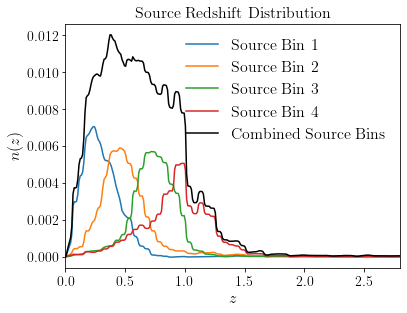

0.6312412596033679


In [14]:
nzs = (T.kernels[0].nzs) #Galaxy counts
zsbin = (T.kernels[0].z) #Source redshift spread
galcount = np.array([24940465,25280405,24891859,25091297]) #Number of galaxies per bin
zs = mean_source_redshift(nzs, zsbin, galcount) #Mean source redshift
print(zs)

We define the lens redshift range and plot the lens redshift distribution.

In [15]:
zlrange = np.linspace(0.005, 0.135, 14)

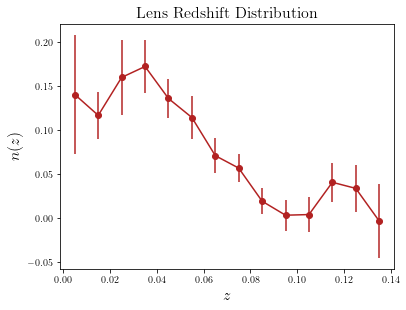

In [16]:
plt.figure(figsize=(6,4.5))
plt.errorbar(zlrange, zldist_red, np.sqrt(np.diag(zldist_red_cov)), marker='o', color='firebrick')
plt.xlabel('$z$', fontsize=16)
plt.ylabel('$n(z)$', fontsize=16)
plt.title('Lens Redshift Distribution', fontsize=16)
plt.show()

### Tangential Shear Model Parameters

We define the parameters for the tangential shear model. We establish two mass parameters corresponding to the subhalo and host halo terms. We include both best-fit and upper bound parameters. We define the angular separations (derived from the shear measurements) and convert them from arcminutes to radians (theta_rad). We set up the mean offset angular separation (offset, arcminutes). We define the number of realizations (n) and the number of data entries (m) to calculate the Hartlap-Kaufman factor. 

In [17]:
theta_rad = theta_red/60*np.pi/180 
subhalo_mass = 10**7.0
subhalo_mass_upper = 10**11.51
hosthalo_mass = 10**12.98
hosthalo_mass_upper = 10**12.96
offset = 36.6
offset_upper =  37.14 
n = 100
m = 22

## Tangential Shear Model

We call for two iterations of the total tangential shear model, corresponding to best-fit and upper bound parameters. 

In [18]:
#Call for model
total_model_bestfit = total_model_func(subhalo_mass = subhalo_mass, hosthalo_mass = hosthalo_mass, zs = zs, zlrange=zlrange, zldist=zldist_red,
                          offset = offset, size_off = 40, scales = theta_rad)

total_model_upperbound = total_model_func(subhalo_mass = subhalo_mass_upper, hosthalo_mass = hosthalo_mass_upper, zs = zs, zlrange=zlrange, zldist=zldist_red,
                          offset = offset_upper, size_off = 40, scales = theta_rad)

### Tangential Shear Model Plot

We compare the tangential shear models to the red LSBG shear measurements. We calculate the physical radius at the mean redshift to define an additional x-axis of physical radii. The errorbars on the measurements come from the jackknife covariance. As a note, we plot the absolute value of the shear measurements. The triangle marker indicates that the selected datapoint has a negative value.

In [19]:
da_rmpc = Planck15.angular_diameter_distance(0.041)
r_mpc_scales = (da_rmpc)*theta_rad

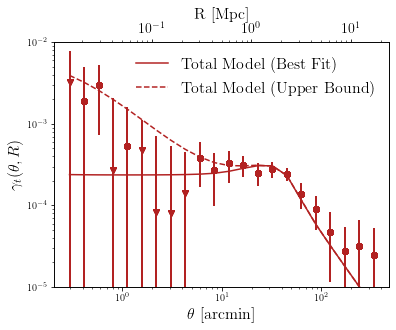

In [20]:
#Plotting measurements over angular scales 
fig, ax1 = plt.subplots(figsize=(6,4.5), ncols=1)
for i in range(len(theta_red)):
        if xi_red[i]>0:
            ax1.errorbar(theta_red, xi_red, err_jk_red, fmt="o", color='firebrick')
        if xi_red[i]<=0:
            ax1.errorbar(theta_red, -1*xi_red, err_jk_red, fmt="v", color='firebrick')
ax2 = ax1.twiny()

#Plotting model over physical scales
ax2.plot(r_mpc_scales, total_model_bestfit[0], color='firebrick', label = 'Total Model (Best Fit)')
ax2.plot(r_mpc_scales, total_model_upperbound[0], ls='--', color='firebrick', label = 'Total Model (Upper Bound)')

ax1.set_ylabel(r'$\gamma_t(\theta, R)$', fontsize=16)
ax1.set_xlabel('$\\theta$ [arcmin]', fontsize=16)
ax2.set_xlabel('R [Mpc]', fontsize=16)

ax2.legend(frameon=False, fontsize=16)
plt.tick_params(axis='both', labelsize=14)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(1e-5, 1e-2)
ax2.set_xscale('log')
ax2.set_yscale('log')
plt.show()


We include the $\chi^2$ calculations between the model and the red LSBG tangential shear measurements to evaluate the strength of the fit.

In [21]:
#Chi2 calculation between model and measurements
chi2_upper = chi2(cov=cov_red, model=total_model_upperbound[0], measurements=np.reshape(xi_red, (22,1)), n=n, m=m)
print(chi2_upper)

chi2_total = chi2(cov=cov_red, model=total_model_bestfit[0], measurements=np.reshape(xi_red, (22,1)), n=n, m=m)
print(chi2_total)

[[26.15954394]]
[[10.60103865]]
